In [1]:
from algorithms.matrix_free_rsvd import MatrixFreeRSVD, tikhonov_solver, get_approximate_W
from utils.mesh_utils import get_square_f
from fenics import UnitSquareMesh, FunctionSpace, Function, plot

import numpy as np
from scipy.sparse.linalg import LinearOperator, cg
from scipy.sparse import diags, eye, kron, vstack


/home/elias/miniforge3/envs/fenics_env/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [12]:
# Function space
n = 1024
mesh = UnitSquareMesh(n, n)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
x0, y0, width, height = 0.65, 0.65, 0.15, 0.15
f = get_square_f(V_h, x0, y0, w=width, h=height)
x = f.vector().get_local()
y = rsvd.apply_K(x)

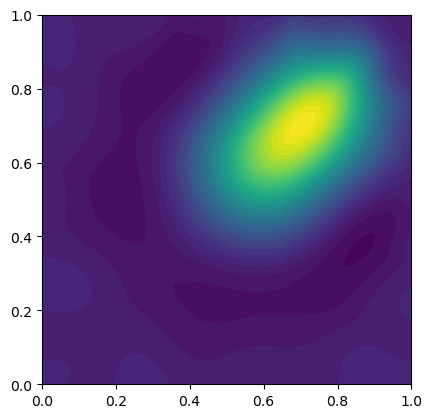

In [13]:
k = 25
Uk, Sk, VkT = rsvd.mf_rsvd(k=k)
w = get_approximate_W(VkT.T, rsvd.M_dx)
x = tikhonov_solver(rsvd, w, y, lambda_=1e-3)

f = Function(V_h)
f.vector()[:] = x
plot(f)

In [40]:
import numpy as np
from scipy.sparse import issparse, csr_matrix, diags, eye, kron, vstack
from scipy.sparse.linalg import LinearOperator, cg
from fenics import Function

def soft_threshold(a, kappa):
    return np.sign(a) * np.maximum(np.abs(a) - kappa, 0)

def get_discrete_grad(nx, ny):
    """Creates D = [Dx; Dy] for a (nx * ny) flattened grid."""
    # Dx: Differences along rows
    dx_main = np.ones(nx)
    dx_main[-1] = 0 # No gradient past the last column
    Dx_1d = diags([-dx_main, dx_main[:-1]], [0, 1], shape=(nx, nx))
    Dx = kron(eye(ny), Dx_1d)

    # Dy: Differences along columns
    dy_main = np.ones(ny)
    dy_main[-1] = 0 # No gradient past the last row
    Dy_1d = diags([-dy_main, dy_main[:-1]], [0, 1], shape=(ny, ny))
    Dy = kron(Dy_1d, eye(nx))

    return vstack([Dx, Dy]).tocsr()

def tv_rsvd_solver(rsvd: MatrixFreeRSVD, y, lambda_tv=0.1, rho=1.0, max_iter=50):
    # Extract RSVD components
    Uk, sk, Vk = rsvd.Uk, rsvd.Sk, rsvd.VkT.T
    M_ds = rsvd.M_ds
    N = Vk.shape[0]
    nx = ny = int(np.sqrt(rsvd.N))

    # 1. Setup Grid Gradient (D)
    # Note: We apply D to the GRID-ORDERED vector
    D = get_discrete_grad(nx, ny)
    
    # 2. Initialize ADMM variables (all in grid-order)
    x_grid = np.zeros(N) 
    z = np.zeros(2 * N) # Dual variable for the L1 term
    u = np.zeros(2 * N) # Lagrange multiplier
    
    # Pre-map everything to grid-order for speed
    # We need a version of the operator that expects grid-ordered input
    V_grid = Vk[rsvd.grid_indices, :]
    Kty_grid = V_grid @ (sk * (Uk.T @ (M_ds @ y)))

    print(f"Starting ADMM (lambda={lambda_tv}, rho={rho})...")

    for i in range(max_iter):
        # --- Step 1: x-update (The 'PDE' solve) ---
        # Solve: (K^T M_ds K + rho*D^T D) x = K^T M_ds y + rho*D^T(z - u)
        rhs = Kty_grid + rho * (D.T @ (z - u))
        
        def lhs_action(v):
            # Term 1: K^T M_ds K v
            Kv = Uk @ (sk * (V_grid.T @ v))
            t1 = V_grid @ (sk * (Uk.T @ (M_ds @ Kv)))
            # Term 2: rho * D^T D v
            t2 = rho * (D.T @ (D @ v))
            return t1 + t2
        
        A_op = LinearOperator((N, N), matvec=lhs_action)
        x_grid, info = cg(A_op, rhs, x0=x_grid, tol=1e-6)

        # --- Step 2: z-update (Soft Thresholding / Shrinkage) ---
        Dx_curr = D @ x_grid
        z = soft_threshold(Dx_curr + u, lambda_tv / rho)

        # --- Step 3: u-update (Dual Update) ---
        u = u + (Dx_curr - z)

        if i % 10 == 0:
            residual = np.linalg.norm(Dx_curr - z)
            print(f" Iter {i:3d} | Primal Residual: {residual:.4e}")

    # Map back to FEniCS DOF order
    x_fenics = x_grid[rsvd.dof_indices]
    f_sol = Function(rsvd.V_h)
    f_sol.vector()[:] = x_fenics
    return f_sol

def weighted_soft_threshold(a, kappa_vec):
    """Pointwise shrinkage with a vector of thresholds."""
    return np.sign(a) * np.maximum(np.abs(a) - kappa_vec, 0)

def tv_weighted_rsvd_solver(rsvd, y, w_diag, lambda_tv=0.1, rho=1.0, max_iter=50):
    Uk, sk, Vk = rsvd.Uk, rsvd.Sk, rsvd.VkT.T
    M_ds = rsvd.M_ds
    N = Vk.shape[0]
    grid_indices = rsvd.grid_indices
    
    # 1. Setup Grid Gradient and Weights
    nx = ny = int(np.sqrt(rsvd.N))
    D = get_discrete_grad(nx, ny)
    
    # Map nodal weights to grid order
    w_grid = w_diag[grid_indices]
    
    # Map nodal weights to edge weights (for Dx and Dy)
    # We repeat the nodal weights for the two components of the gradient
    # A simple approximation: edges inherit the weight of the starting node
    w_edge = np.concatenate([w_grid, w_grid]) 
    
    # Pre-calculate the shrinkage threshold vector
    kappa_vec = (lambda_tv * w_edge) / rho

    # 2. ADMM Variables (Grid Order)
    x_grid = np.zeros(N)
    z = np.zeros(2 * N)
    u = np.zeros(2 * N)
    
    V_grid = Vk[grid_indices, :]
    Kty_grid = V_grid @ (sk * (Uk.T @ (M_ds @ y)))

    for i in range(max_iter):
        # --- Step 1: x-update (Standard CG Solve) ---
        rhs = Kty_grid + rho * (D.T @ (z - u))
        
        def lhs_action(v):
            Kv = Uk @ (sk * (V_grid.T @ v))
            t1 = V_grid @ (sk * (Uk.T @ (M_ds @ Kv)))
            t2 = rho * (D.T @ (D @ v))
            return t1 + t2
        
        A_op = LinearOperator((N, N), matvec=lhs_action)
        x_grid, _ = cg(A_op, rhs, x0=x_grid, tol=1e-6)

        # --- Step 2: Weighted z-update ---
        Dx_curr = D @ x_grid
        # Shrinkage now uses the spatially varying kappa_vec
        z = weighted_soft_threshold(Dx_curr + u, kappa_vec)

        # --- Step 3: u-update ---
        u = u + (Dx_curr - z)

        if i % 10 == 0:
            print(f"Iter {i} | Res: {np.linalg.norm(Dx_curr - z):.2e}")

    # Return to FEniCS order
    f_sol = Function(rsvd.V_h)
    f_sol.vector()[:] = x_grid[rsvd.dof_indices]
    return f_sol


def get_weighted_kappa(w_grid, nx, ny, lambda_tv, rho):
    """
    Averages nodal weights to create edge-based thresholds.
    w_grid: Nodal weights in grid-order.
    """
    # Reshape to 2D for easier neighbor access
    W_mat = w_grid.reshape((ny, nx))
    
    # 1. Weights for Dx (Horizontal differences)
    # Average current node and the neighbor to the right
    # For the last column, we just use the node's own weight
    W_x = np.zeros_like(W_mat)
    W_x[:, :-1] = 0.5 * (W_mat[:, :-1] + W_mat[:, 1:])
    W_x[:, -1] = W_mat[:, -1]
    
    # 2. Weights for Dy (Vertical differences)
    # Average current node and the neighbor below
    W_y = np.zeros_like(W_mat)
    W_y[:-1, :] = 0.5 * (W_mat[:-1, :] + W_mat[1:, :])
    W_y[-1, :] = W_mat[-1, :]
    
    # Combine and scale by lambda/rho
    w_edge = np.concatenate([W_x.ravel(), W_y.ravel()])
    return (lambda_tv * w_edge) / rho


def solve_weighted_tv(rsvd, y, w_diag, lambda_tv=0.01, rho=1.0, max_iter=100):
    # Setup
    grid_idx = rsvd.grid_indices
    dof_idx = rsvd.dof_indices
    nx = ny = rsvd.N
    N = len(grid_idx)
    
    # Operators
    D = get_discrete_grad(nx, ny)
    kappa_vec = get_weighted_kappa(w_diag[grid_idx], nx, ny, lambda_tv, rho)
    
    # Pre-map RSVD for grid-order
    V_grid = rsvd.VkT.T[grid_idx, :]
    Kty_grid = V_grid @ (rsvd.Sk * (rsvd.Uk.T @ (rsvd.M_ds @ y)))
    
    # Variables
    x_grid = np.zeros(N)
    z = np.zeros(2 * N)
    u = np.zeros(2 * N)
    
    for i in range(max_iter):
        # f-step: Weighted Tikhonov-like solve
        rhs = Kty_grid + rho * (D.T @ (z - u))
        
        def lhs_op(v):
            # (K^T M_ds K + rho D^T D) v
            Kv = rsvd.Uk @ (rsvd.Sk * (V_grid.T @ v))
            t1 = V_grid @ (rsvd.Sk * (rsvd.Uk.T @ (rsvd.M_ds @ Kv)))
            t2 = rho * (D.T @ (D @ v))
            return t1 + t2
        
        A_op = LinearOperator((N, N), matvec=lhs_op)
        x_grid, _ = cg(A_op, rhs, x0=x_grid, tol=1e-6)
        
        # z-step: Weighted Shrinkage
        Dx = D @ x_grid
        z = np.sign(Dx + u) * np.maximum(np.abs(Dx + u) - kappa_vec, 0)
        
        # u-step: Dual Update
        u += (Dx - z)
        
        if i % 20 == 0:
            p_res = np.linalg.norm(Dx - z)
            print(f"Iteration {i:3d} | Primal Residual: {p_res:.4e}")

    # Map back to FEniCS
    f_out = Function(rsvd.V_h)
    f_out.vector()[:] = x_grid[dof_idx]
    return f_out

/tmp/ipykernel_229218/1107596481.py:125: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x_grid, _ = cg(A_op, rhs, x0=x_grid, tol=1e-6)


Iter 0 | Res: 4.15e-04
Iter 10 | Res: 8.60e-09
Iter 20 | Res: 3.31e-09
Iter 30 | Res: 1.63e-09
Iter 40 | Res: 5.92e-09
Iter 50 | Res: 6.64e-09
Iter 60 | Res: 5.82e-09
Iter 70 | Res: 1.86e-09
Iter 80 | Res: 1.61e-09
Iter 90 | Res: 1.23e-09
Iter 100 | Res: 1.07e-09
Iter 110 | Res: 1.01e-09
Iter 120 | Res: 9.52e-10
Iter 130 | Res: 9.11e-10
Iter 140 | Res: 7.82e-10
Iter 150 | Res: 9.08e-10
Iter 160 | Res: 1.24e-09
Iter 170 | Res: 1.23e-09
Iter 180 | Res: 8.49e-10
Iter 190 | Res: 8.22e-10


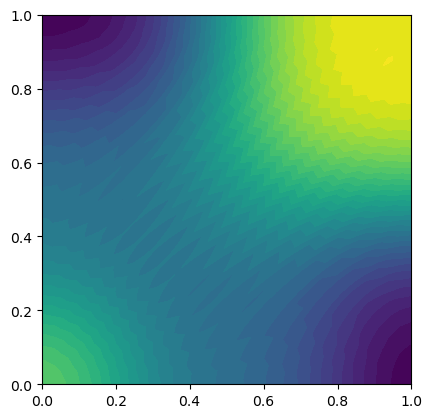

In [52]:
# 1. Define hyperparameters
# lambda_tv: higher means smoother regions, fewer "speckles"
# rho: penalty parameter (1.0 is usually a good starting point)
lambda_val = 1e-4
rho_val = 1.0

# 2. Run the solver
# y is your boundary measurement vector
f_reconstructed = tv_weighted_rsvd_solver(
    rsvd=rsvd,
    y=y,
    w_diag=w,
    lambda_tv=lambda_val,
    rho=rho_val,
    max_iter=200
)

# 3. Plot in FEniCS
from fenics import plot
import matplotlib.pyplot as plt
plot(f_reconstructed)
plt.show()